## Airline Passenger Satisfaction

This notebooks intended for the experimentation and prediction of airline passenger satisfaction.

In [1]:
# importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix

In [2]:
# reading data from local path
df = pd.read_csv('../../data/passenger-data.csv').drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

### Separating the datasets

In [5]:
df['satisfaction'].value_counts()

satisfaction
neutral or dissatisfied    73452
satisfied                  56428
Name: count, dtype: int64

Let's make `satisfied = 1` & `neutral or dissatisfied = 0`

In [6]:
# remapping target variables -> "{satisfied:1, "neutral or dissatisfied: 0"}"
df['satisfaction'] = np.where(df['satisfaction'] == 'satisfied', 1, 0)

In [7]:
# checking for numerical correlations
matrix_corr = df.select_dtypes(exclude=[object]).corr()
mask = np.triu(np.ones_like(matrix_corr), k=0)

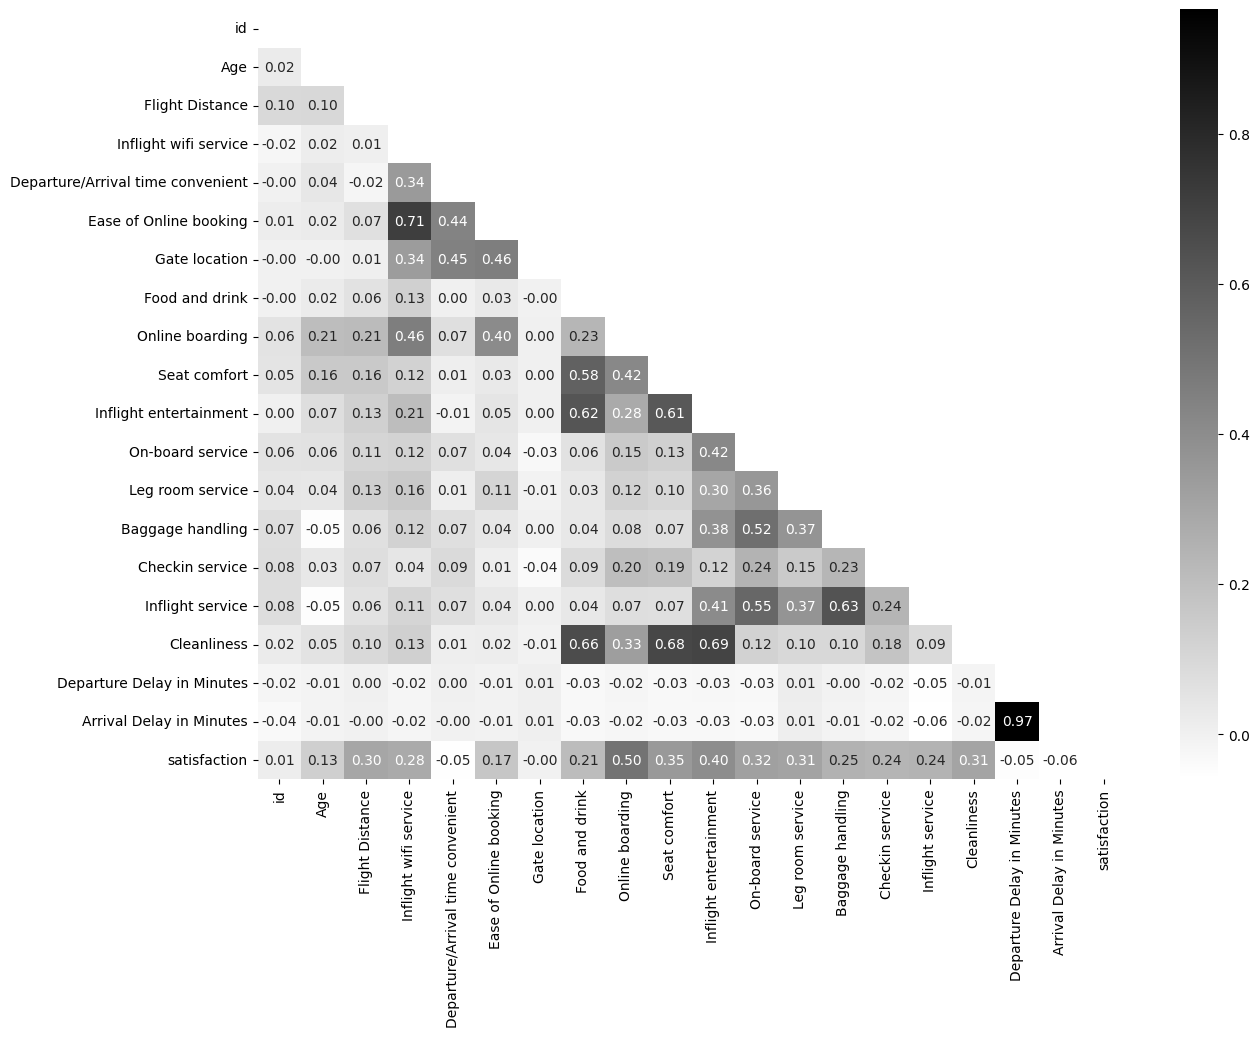

In [8]:
# visualizing correlations using a heatmap
plt.figure(figsize = (14,10))
sns.heatmap(matrix_corr, mask = mask, annot = True, cmap = 'gray_r', fmt = '.2f')
plt.show()

`Arrival Delay in Minutes` & `Departure Delay in Minutes` are 97% correlated, so one of the features will be dropped in addition to `Gender`, `id` & `Gate Location`.

In [9]:
train = df.drop(['Arrival Delay in Minutes', 'satisfaction', 'id', 'Gender', 'Gate location'], axis = 1) 
target = df['satisfaction']

In [10]:
# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify=target, test_size=0.2, random_state=42)

In [11]:
# identifying numerical and categorical variables
num_attribs = X_train.select_dtypes(exclude=object).columns
cat_attribs = X_train.select_dtypes(include=object).columns

In [12]:
# Transformer Class to handle dataframe selection

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attrib_names]

In [13]:
# Transformer Class to handle categorical data encoding

class Encode(BaseEstimator, TransformerMixin):
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X[self.attrib_names].copy()
        X['Customer Type'] = np.where(X['Customer Type'] == 'Loyal Customer', 1, 0)
        X['Type of Travel'] = np.where(X['Type of Travel'] == 'Business travel', 1, 0)
        X = pd.concat([X, X['Class'].str.get_dummies()], axis=1).drop('Class', axis=1)
        return X

In [14]:
# creating a numerical processing pipeline
num_pipeline = Pipeline([
    ('Select dataframe', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

In [15]:
# creating a categorical processing pipeline 
cat_pipeline = Pipeline([
    ('cat_encoder', Encode(cat_attribs))
])

In [16]:
# full transformation pipeline
full_pipeline = FeatureUnion(transformer_list = [
    ('numerical', num_pipeline),
    ('categorical', cat_pipeline)
])

In [17]:
# applying transformation pieline
X_train_scaled = full_pipeline.fit_transform(X_train)
X_test_scaled = full_pipeline.transform(X_test)

#### Baseline

In [18]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_scaled, y_train)
dummy_pred = dummy.predict(X_train_scaled)

In [19]:
pd.Series(dummy_pred).value_counts(normalize=True)

0    0.565358
1    0.434642
Name: proportion, dtype: float64

In [20]:
y_train.value_counts(normalize=True)

satisfaction
0    0.565541
1    0.434459
Name: proportion, dtype: float64

In [21]:
print(classification_report(dummy_pred, y_train))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56     58743
           1       0.43      0.43      0.43     45161

    accuracy                           0.51    103904
   macro avg       0.50      0.50      0.50    103904
weighted avg       0.51      0.51      0.51    103904



#### RandomForest Classifier

In [22]:
model = RandomForestClassifier(random_state = 11)

In [23]:
model.fit(X_train_scaled, y_train)
pred = cross_val_predict(model, X_train_scaled, y_train, cv = 3)
score = f1_score(y_train, pred)
pr_score = precision_score(y_train, pred)
re_score = recall_score(y_train, pred)
score2 = roc_auc_score(y_train, pred)
print(f'{model.__class__.__name__}: {score:.4f}')
print(f'precision score: {pr_score:.4f}')
print(f'recall score: {re_score:.4f}')
print(f'ROC score: {score2:.4f}\n')

RandomForestClassifier: 0.9550
precision score: 0.9703
recall score: 0.9402
ROC score: 0.9590



In [24]:
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     58762
           1       0.97      0.94      0.96     45142

    accuracy                           0.96    103904
   macro avg       0.96      0.96      0.96    103904
weighted avg       0.96      0.96      0.96    103904



### Precision Recall Curve

In [25]:
proba = cross_val_predict(model, X_test_scaled, y_test, cv = 3, method = 'predict_proba')

In [26]:
precisions, recalls, thresholds = precision_recall_curve(y_test, proba[:,1])

In [27]:
recall_thr = recalls[:-1][thresholds==0.5][0]
precision_thr = precisions[:-1][thresholds==0.5][0]

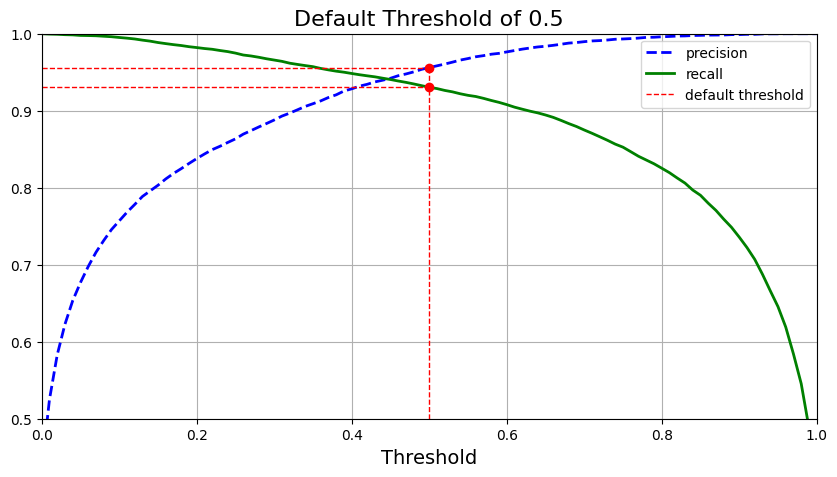

In [28]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', lw = 2)
plt.plot(thresholds, recalls[:-1], 'g', label = 'recall', lw = 2)
plt.plot([0.5,0.5],[0.5,max(recall_thr, precision_thr)], 'r--', lw = 1, label = 'default threshold')
plt.plot([0,0.5],[recall_thr, recall_thr], 'r--', lw = 1)
plt.plot([0,0.5],[precision_thr,precision_thr], 'r--', lw = 1)
plt.plot([0.5],[recall_thr], 'o', color = 'red')
plt.plot([0.5],[precision_thr], 'o', color = 'red')
plt.axis([0,1,0.5,1.0])
plt.xlabel('Threshold', fontsize = 14)
plt.title('Default Threshold of 0.5', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

In [29]:
# confusion matrix
conf_matrix_pred = cross_val_predict(model, X_test_scaled, y_test, cv = 3)

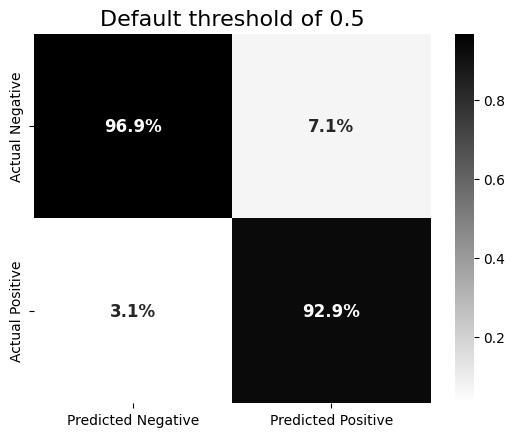

In [30]:
conf_matrix = confusion_matrix(conf_matrix_pred, y_test)
conf_matrix = conf_matrix / conf_matrix.sum(axis=0)
sns.heatmap(conf_matrix, annot = True, fmt = '.1%', cmap = 'gray_r', xticklabels = ['Predicted Negative','Predicted Positive'],
           yticklabels = ['Actual Negative','Actual Positive'], annot_kws = {'weight':'bold', 'size':12})
plt.title('Default threshold of 0.5', fontsize = 16)
plt.show()

Depending on the business use case the threshold can be tweaked to optimize for precision or recall

If the business goal is to identify ALL passengers that could be dissatisfied, then the threshold can be optimized for a higher recall.

**Increasing Recall**

In [31]:
# precision and recall thresholds
recall_thr = thresholds[np.argmin(recalls >= 0.99)]
precision_thr = precisions[np.argmin(recalls >= 0.99)]

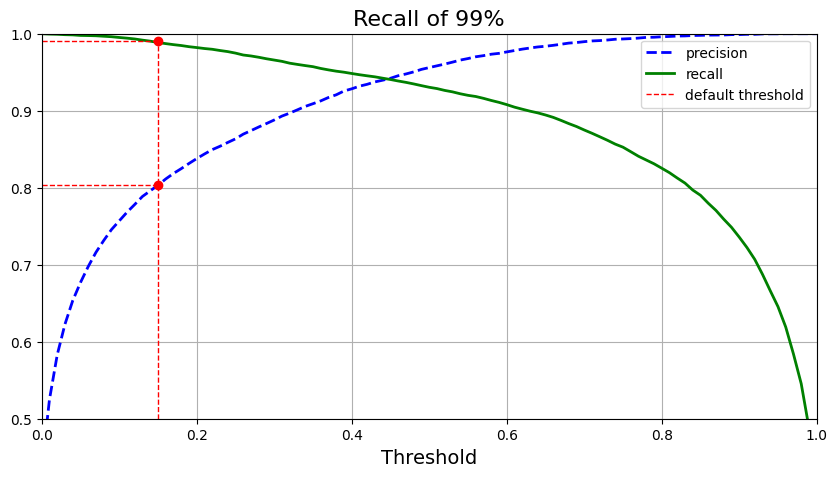

In [32]:
# precision recall curve
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', lw = 2)
plt.plot(thresholds, recalls[:-1], 'g', label = 'recall', lw = 2)
plt.plot([recall_thr, recall_thr],[0.5,.99], 'r--', lw = 1, label = 'default threshold')
plt.plot([0,recall_thr],[0.99,0.99], 'r--', lw = 1)
plt.plot([0,recall_thr],[precision_thr,precision_thr], 'r--', lw = 1)
plt.plot([recall_thr],[0.99], 'o', color = 'red')
plt.plot([recall_thr],[precision_thr], 'o', color = 'red')
plt.axis([0,1,0.5,1.0])
plt.xlabel('Threshold', fontsize = 14)
plt.title('Recall of 99%', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

To achieve a model with 99% recall, the decision threshold will be reduced from 0.5 to 0.14

To achieve a higher precision, we just do the opposite above

### ROC Curve

In [33]:
# false positive and true positive rate 
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])

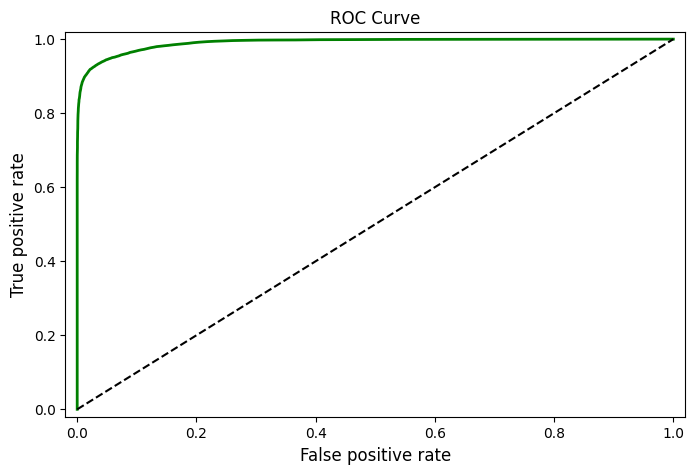

In [34]:
# Receiver Operating Characteristic Curve
plt.figure(figsize = (8,5))
plt.plot(fpr, tpr, 'g', lw = 2)
plt.plot([0,1],[0,1], 'k--')
plt.axis([-0.02,1.02,-0.02,1.02])
plt.xlabel('False positive rate', fontsize = 12)
plt.ylabel('True positive rate', fontsize = 12)
plt.title('ROC Curve')
plt.show()